In [44]:
# Import libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import kagglehub
import os

In [23]:
# Load the data
dataset_dir = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv(fr'{dataset_dir}/Combined Data.csv', index_col=0)

/Users/tylergarriott/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv


In [24]:
# Display the first few rows of the dataframe
print(df.head())

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


In [25]:
# EDA
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


In [26]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
statement    362
status         0
dtype: int64


In [27]:
# Handle NaN values in the statement column
df['statement'] = df['statement'].fillna('')

In [28]:
# Text Length Distribution
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

In [29]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylergarriott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylergarriott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tylergarriott/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [30]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [31]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df['statement'].apply(augment_text)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augmented_statement']
df = pd.concat([df, augmented_df])

In [32]:
# Reapply preprocessing on augmented data
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [33]:
# Ensure no NaN values are left
df['cleaned_statement'] = df['cleaned_statement'].fillna('')

In [34]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

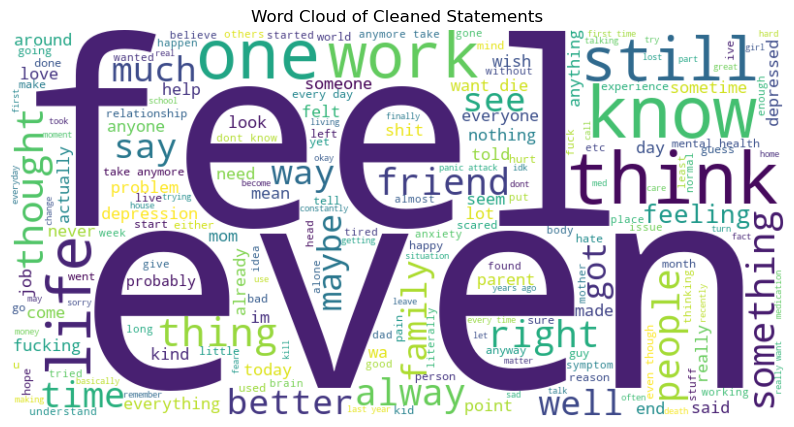

In [35]:
# Summarize good data

# Class 'Status' Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()

# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [36]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Vectorization: Convert text values to numeric values for calculation
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [38]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [39]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [40]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 100}
Accuracy Score:
0.8663399000848336
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.92      0.91      0.92      1562
             Bipolar       0.93      0.90      0.92      1150
          Depression       0.83      0.83      0.83      6182
              Normal       0.93      0.96      0.94      6571
Personality disorder       0.85      0.81      0.83       447
              Stress       0.89      0.85      0.87      1047
            Suicidal       0.78      0.77      0.77      4259

            accuracy                           0.87     21218
           macro avg       0.88      0.86      0.87     21218
        weighted avg       0.87      0.87      0.87     21218



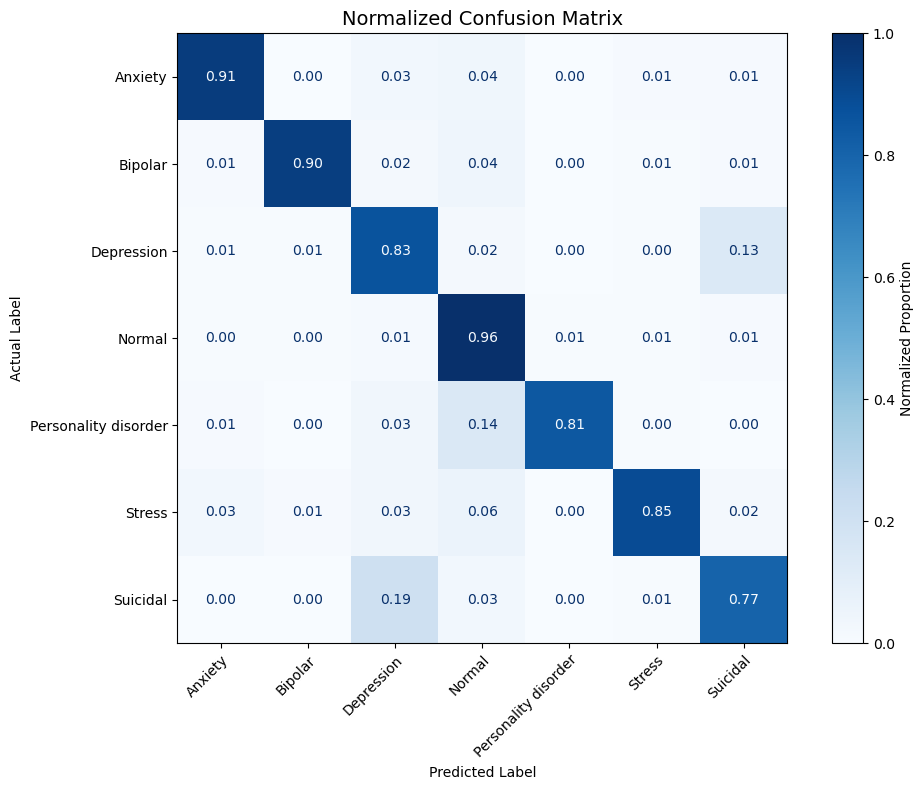

In [41]:
# Compute normalized confusion matrix
labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", colorbar=False)

# Colorbar with full range from 0 to 1
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Proportion')
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)])

# Label formatting
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Titles and axis labels
ax.set_title("Normalized Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

In [42]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()

In [45]:
# Define number of bootstrap samples
n_bootstraps = 1000
rng = np.random.RandomState(42)

# Store bootstrap results
acc_scores = []
f1_scores = []

# Create bootstrapped datasets
for _ in range(n_bootstraps):
    # Resample with replacement
    indices = rng.randint(0, len(y_test), len(y_test))
    y_true_sample = np.array(y_test)[indices]
    y_pred_sample = np.array(y_pred)[indices]

    acc_scores.append(accuracy_score(y_true_sample, y_pred_sample))
    f1_scores.append(f1_score(y_true_sample, y_pred_sample, average='macro'))

# Convert to NumPy arrays
acc_scores = np.array(acc_scores)
f1_scores = np.array(f1_scores)

# Compute 95% confidence intervals
acc_ci = np.percentile(acc_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

print(f"Accuracy CI (95%): {acc_ci[0]:.4f} to {acc_ci[1]:.4f}")
print(f"Macro F1 CI (95%): {f1_ci[0]:.4f} to {f1_ci[1]:.4f}")

Accuracy CI (95%): 0.8620 to 0.8707
Macro F1 CI (95%): 0.8621 to 0.8741


In [46]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"CV mean accuracy: {np.mean(cv_scores):.4f}")
print(f"CV std deviation: {np.std(cv_scores):.4f}")

CV mean accuracy: 0.7874
CV std deviation: 0.0025
